In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from numpy import array
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error


In [22]:
stock_xiaomi = pd.read_csv('Xiaomi_clean.csv')
stock_xiaomi

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-07-09,16.600000,17.000000,16.000000,16.799999,16.799999,462182642
1,2018-07-10,17.000000,19.340000,17.000000,19.000000,19.000000,534072218
2,2018-07-11,18.500000,19.799999,18.299999,19.000000,19.000000,374721138
3,2018-07-12,19.400000,19.700001,19.020000,19.260000,19.260000,132592630
4,2018-07-13,19.600000,21.799999,19.520000,21.450001,21.450001,364065075
...,...,...,...,...,...,...,...
1795,2025-10-22,46.000000,46.740002,45.700001,46.340000,46.340000,121391262
1796,2025-10-23,46.020000,47.080002,45.700001,46.740002,46.740002,106829656
1797,2025-10-24,47.099998,47.400002,45.740002,45.919998,45.919998,170946122
1798,2025-10-27,45.720001,46.000000,43.880001,45.799999,45.799999,282836746


In [23]:
stock_xiaomi['Date'] = pd.to_datetime(stock_xiaomi['Date'])
stock_xiaomi = stock_xiaomi.set_index(pd.DatetimeIndex(stock_xiaomi['Date'].values))
df_xiaomi = pd.DataFrame(stock_xiaomi, columns=['Close'])


In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
df_xiaomi_scaled = scaler.fit_transform(np.array(df_xiaomi).reshape(-1,1))

In [25]:
train_size = int(len(df_xiaomi_scaled) * 0.6)
val_size = int(len(df_xiaomi_scaled) * 0.2)
test_size = len(df_xiaomi_scaled) - train_size - val_size

train_data = df_xiaomi_scaled[:train_size]
val_data = df_xiaomi_scaled[train_size:train_size+val_size]
test_data = df_xiaomi_scaled[train_size+val_size:]

In [26]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 100

In [27]:
train_last_window = train_data[-time_step:]
val_data_extended = np.concatenate((train_last_window, val_data), axis=0)
val_last_window = val_data[-time_step:]
test_data_extended = np.concatenate((val_last_window, test_data), axis=0)

X_train, y_train = create_dataset(train_data, time_step)
X_val, y_val = create_dataset(val_data_extended, time_step)
X_test, y_test = create_dataset(test_data_extended, time_step)

In [28]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [29]:
from keras.layers import Input

model = Sequential()
# Dùng Input ở layer đầu tiên
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='adam')


In [30]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,        # Số epoch bạn muốn train
    batch_size=32,    # batch size
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - loss: 0.0053 - val_loss: 7.3421e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 9.5214e-04 - val_loss: 2.3009e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 8.4974e-04 - val_loss: 2.5821e-04
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 7.8178e-04 - val_loss: 1.9966e-04
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 8.1444e-04 - val_loss: 1.6643e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 7.3127e-04 - val_loss: 1.8682e-04
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 83ms/step - loss: 6.5073e-04 - val_loss: 2.2120e-04
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 6.6447e-04 - val_loss: 1.4341e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 5.9530e-04 - val_loss: 1.4007e-04
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 6.2245e-04 - val_loss: 1.6013e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 5.8927e-04 -

In [31]:
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


In [32]:
val_mape = mean_absolute_percentage_error(y_pred_val, y_val)
val_mse = mean_squared_error(y_pred_val, y_val)
val_rmse = np.sqrt(val_mse)
val_msle = mean_squared_log_error(y_pred_val, y_val)
print(f"Validation MAPE: {val_mape}")
print(f"Validation RMSE: {val_rmse}")
print(f"Validation MSLE: {val_msle}")

Validation MAPE: 0.09473305715505699
Validation RMSE: 0.00907530552108884
Validation MSLE: 6.886408085396344e-05


In [33]:
test_mape = mean_absolute_percentage_error(y_pred_test, y_test)
test_mse = mean_squared_error(y_pred_test, y_test)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(y_pred_test, y_test)
print(f"Test MAPE: {test_mape}")
print(f"Test RMSE: {test_rmse}")
print(f"Test MSLE: {test_msle}")

Test MAPE: 0.03947893917449988
Test RMSE: 0.02874046522986862
Test MSLE: 0.0002862583806042287


In [34]:
x_input = test_data[5:].reshape(1,-1)
temp_input = list(x_input[0])
prediction_next30_days = []

for i in range(30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[-time_step:])
        x_input = x_input.reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())
    else:
        x_input = np.array(temp_input).reshape((1, time_step, 1))
        y_hat = model.predict(x_input, verbose=0)
        temp_input.extend(y_hat[0].tolist())
        prediction_next30_days.extend(y_hat.tolist())

In [35]:
last_date = stock_xiaomi.index.max()
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30, freq='D')

In [36]:
prediction_next30_days = scaler.inverse_transform(prediction_next30_days).reshape(-1)
y_pred_test = scaler.inverse_transform(y_pred_test)
y_pred_val = scaler.inverse_transform(y_pred_val)
train_data_inv = scaler.inverse_transform(train_data) 
val_data_inv = scaler.inverse_transform(val_data)
test_data_inv = scaler.inverse_transform(test_data)

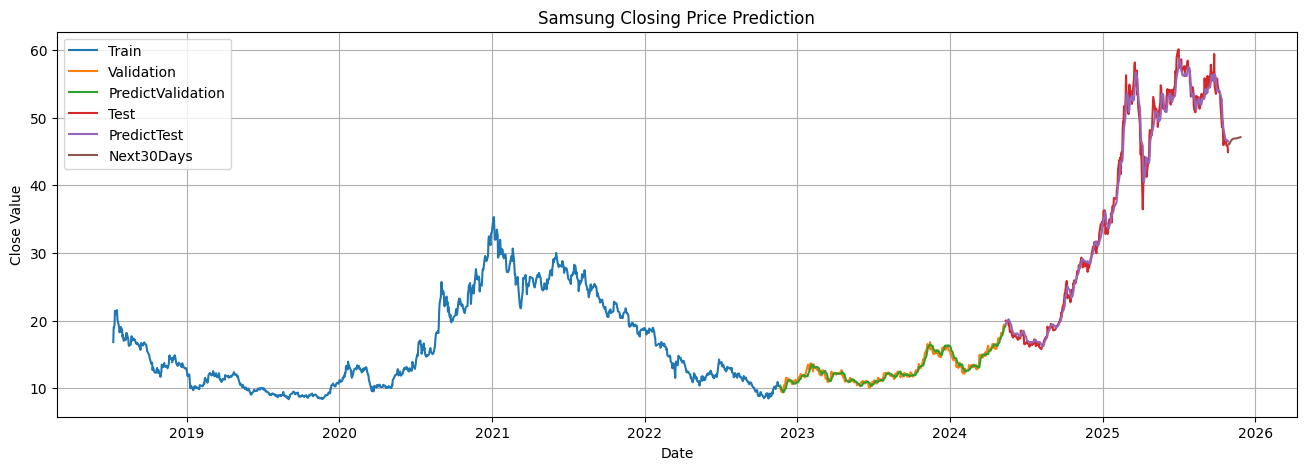

In [37]:
plt.figure(figsize=(16,5))
plt.plot(stock_xiaomi.index[:train_size], train_data_inv)
plt.plot(stock_xiaomi.index[train_size:train_size+val_size], val_data_inv)
plt.plot(stock_xiaomi.index[train_size:train_size+val_size], y_pred_val)
plt.plot(stock_xiaomi.index[train_size+val_size:], test_data_inv)
plt.plot(stock_xiaomi.index[train_size+val_size:], y_pred_test)
plt.plot(future_dates, prediction_next30_days)
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.title('Samsung Closing Price Prediction')
plt.legend(['Train','Validation','PredictValidation','Test','PredictTest','Next30Days'])
plt.grid()
plt.show()